In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load and preprocess the dataset
df = pd.read_csv('combined_dataset.csv')
df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
df.set_index(df.columns[0], inplace=True)
y = df['NASDAQ_Volatility']
X = df.select_dtypes(include=[np.number]).drop(columns=['NASDAQ_Volatility'])

# Handling Multicollinearity
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

vif_data = calculate_vif(X)
while vif_data['VIF'].max() > 10:  # Adjust the threshold as necessary
    highest_vif = vif_data['VIF'].idxmax()
    X.drop(columns=vif_data.loc[highest_vif, 'feature'], inplace=True)
    vif_data = calculate_vif(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Grid Search for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train_pca, y_train)

# Displaying the best parameter combination and corresponding score
print("Best parameter combination:", grid.best_params_)
print("Best model score:", grid.best_score_)

# Predicting and Evaluating the Model
y_pred = grid.predict(X_test_pca)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

Mean Squared Error: 3.041162118648162e-07


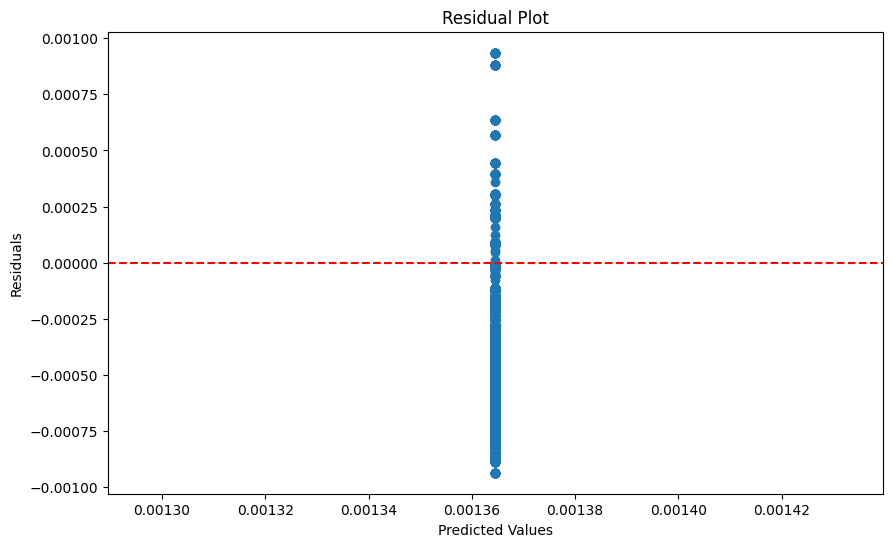

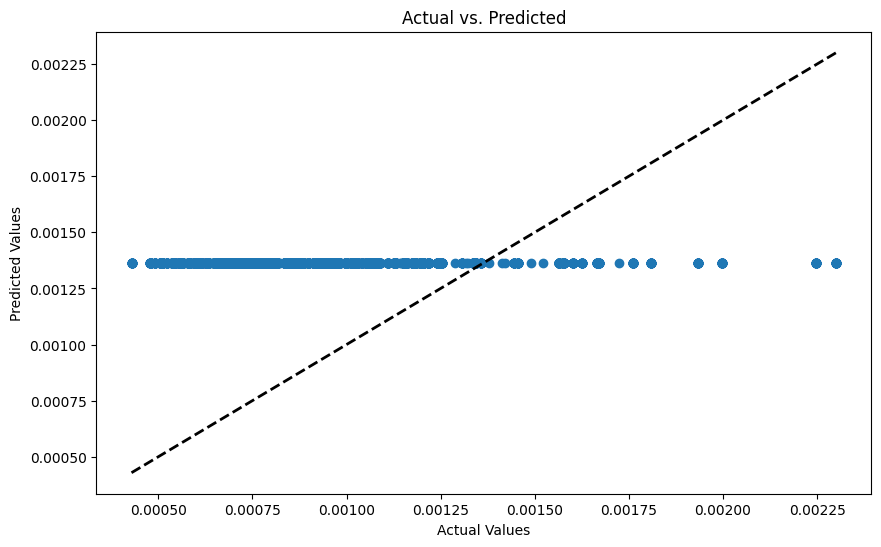

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Already calculated Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()
